In [3]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

In [4]:
expt = nsx.Experiment('test', 'BioDiff2500')
biodiff = expt.getDiffractometer()
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202_newer.hdf", biodiff)
data = nsx.DataSet(reader, biodiff)
expt.addData(data)

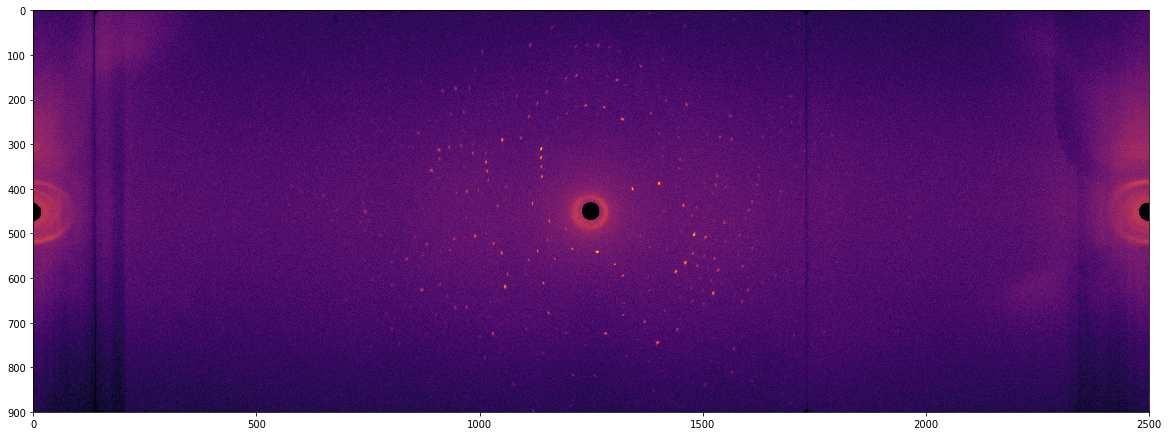

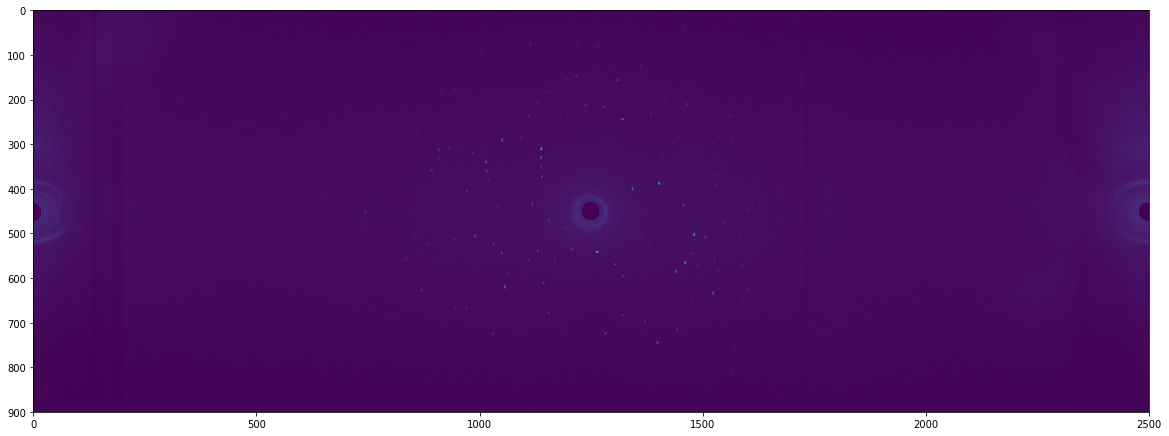

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)), cmap='inferno')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(data.getFrame(0))
plt.show()

In [6]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [7]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

numors = nsx.vector_data()
numors.push_back(data)
peaks = finder.find(numors)
print(peaks.size())

9203


In [8]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

num_to_index = 0
fit_data = []

for peak in peaks:
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
#handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

print("found solution, A:\n", soln[0].basis())


indexing 8263 peaks
found solution, A:
 [[ -2.74387351  58.51879625  -0.40209272]
 [ 14.81441529   0.44569576 -64.29279643]
 [ 52.97982209   2.90611494  17.95696658]]


In [12]:
uc = nsx.UnitCell(soln[0])
sample = biodiff.sample()
sample.addUnitCell(uc)

qs = []
hkls = []

for peak in peaks:
    if not peak.isSelected():
        continue
        
    if peak.isMasked():
        continue
        
    q = peak.getQ().rowVector()
    d = 1.0 / np.linalg.norm(q)
    
    if d < 2.0 or d > 50.0:
        continue
        
    peak.addUnitCell(uc, True)
    
    hkl = np.array([[0.,0.,0.]])    
    success = uc.getMillerIndices(peak.getQ(), hkl)
    
    if not success:
        continue
    
    qs.append(q)
    hkls.append(hkl)
    
npeaks = len(qs)

print("done indexing peaks")

print(uc.reciprocalBasis())
ch = uc.character()
print(ch.a, ch.b, ch.c)
print(ch.alpha*180.0/math.pi, ch.beta*180.0/math.pi, ch.gamma*180.0/math.pi)

done indexing peaks
[[ -9.04417461e-04   4.88302971e-03   1.74628590e-02]
 [  1.70454995e-02   1.29823362e-04   8.46500337e-04]
 [ -9.02326440e-05  -1.44277891e-02   4.02967893e-03]]
55.08046197376388 58.59260758212346 66.75461033210665
89.99999999999999 90.0 90.0


In [50]:
# create peak batches

nbatches = int(data.getNFrames() / 10)
#nbatches = 1
fmin = 0.0
fmax = data.getNFrames()+1
df = (fmax-fmin) / nbatches

q_batches = [ [] for i in range(nbatches) ]
hkl_batches = [ [] for i in range(nbatches) ]
frame_batches = [ [] for i in range(nbatches) ]
center_batches = [ [] for i in range(nbatches) ]
peak_batches = [ [] for i in range(nbatches) ]

for peak in peaks:
    if not peak.isSelected():
        continue
        
    if peak.isMasked():
        continue       
       
    q = peak.getQ().rowVector()
    d = 1.0 / np.linalg.norm(q)
    
    if d < 2.0 or d > 50.0:
        continue
        
    hkl = np.array([[0.,0.,0.]])    
    success = uc.getMillerIndices(peak.getQ(), hkl)
    
    if not success:
        continue
               
    frame = peak.getShape().center()[2,0]    
    batch = int(frame/df)
    #print(batch)  
    
    q_batches[batch].append(peak.getQ().rowVector())
    hkl_batches[batch].append(hkl)
    frame_batches[batch].append(frame)
    center_batches[batch].append(peak.getShape().center())
    peak_batches[batch].append(peak)
    
print(len(peaks))

9203


In [15]:
states = []

for i in range(data.getNFrames()):
    states.append(data.getInterpolatedState(i))

In [ ]:
gonio = data.getDiffractometer().sample().getGonio()
u = np.array([1.,0.,0.])
v = np.array([0.,1.,0.])
w = np.array([0.,0.,1.])

gonio.transformInPlace(u, states[10].sample)
gonio.transformInPlace(v, states[10].sample)
gonio.transformInPlace(w, states[10].sample)

print(u, v, w)


In [16]:
from scipy.optimize import least_squares


def encode(ki, ub):
    #return np.append(ki, ub.reshape((9)))
    #return np.array([0.,0.,0.])
    return ub.reshape((9))

def decode(x):
    #return x[:3], x[3:].reshape((3,3))
    #return x, uc.reciprocalBasis()
    return np.array([0.,0.,0.]), x.reshape((3,3))

def residual(x, qs, hkls, frames):
    n = len(qs)
    assert(n == len(hkls))
    
    ki_offset, basis = decode(x)    
    #basis = x.resize((3,3))
    fvec = np.zeros(3*n)
    
    for i in range(n):
        state = data.getInterpolatedState(frames[i])
        dq = hkls[i][0].dot(basis)-qs[i][0]-gonio.transformInverse(ki_offset, state.sample)[0]
        #print(dq)

        for j in range(3):
            fvec[3*i+j] = dq[j]
    
    return fvec

ki_offsets = []
bases = []

test = nsx.UnitCell(uc)
test.setReciprocalBasis(uc.reciprocalBasis())
ch = test.character()
print(ch.a, ch.b, ch.c)

for i in range(nbatches):
    x0 = encode([0,0,0], uc.reciprocalBasis())
    ch = uc.character()
    #print('starting character: ', ch.a, ch.b, ch.c)
    
    result = least_squares(lambda x: residual(x, q_batches[i], hkl_batches[i], frame_batches[i]), x0)  
    ki, basis = decode(result.x)
    
    batch_uc = nsx.UnitCell(uc)
    batch_uc.setReciprocalBasis(basis)
    
    ch = batch_uc.character()
    print('character', ch.a, ch.b, ch.c)#, ch.alpha, ch.beta, ch.gamma)
    
    UA = np.linalg.inv(basis)
    #print(basis)
    bases.append(basis)
    ki_offsets.append(ki)

    print('status: ', result.success, result.status)
    print('mse: ', result.fun.std())
    print('ki-offset: ', ki)
    print('-------------------------------------------------------')

55.08046197376388 58.592607582123456 66.75461033210665


NameError: name 'gonio' is not defined

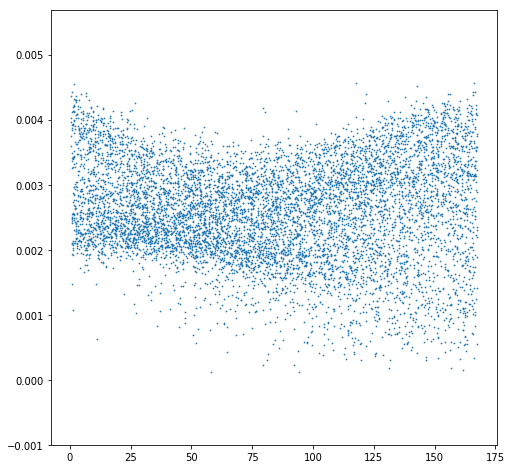

In [24]:
frames = []
dq = []

for i in range(nbatches):
    qs = [ np.linalg.norm(q) for q in q_batches[i] ]
    #preds = [ hkl[0]*bases[i]-ki_offsets[i] for hkl in hkl_batches[i] ]    
    #dq = [ np.linalg.norm(qs[j]-preds[j]) for j in range(len(q_batches[i]))]
    
    preds = [hkl[0].dot(uc.reciprocalBasis()) for hkl in hkl_batches[i]]
    
    frames.extend([ frame for frame in frame_batches[i] ])
   
    
    dqq = [ np.linalg.norm(preds[j]-q_batches[i][j]) / np.linalg.norm(q_batches[i][j]) for j in range(len(preds)) ]
    #dq = [ np.linalg.norm(preds[j]-q_batches[i][j]) for j in range(len(preds)) ]
    #ädq = [ np.linalg.norm(preds[j]-qs[j]) for j in range(len(preds)) ]
    
    for j in range(len(preds)):
        #frames.append(frame)
        dq.append(np.linalg.norm(preds[j]-q_batches[i][j]))
    
    
    #ädhkls = [ np.linalg.norm(q) ]
    
plt.figure(figsize=(8,8))
plt.scatter(frames, dq, s=0.5)
plt.show()

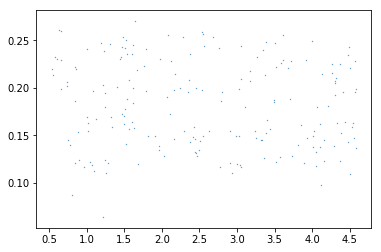

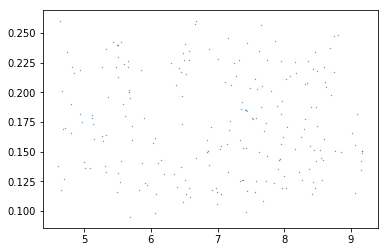

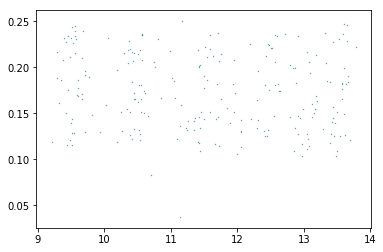

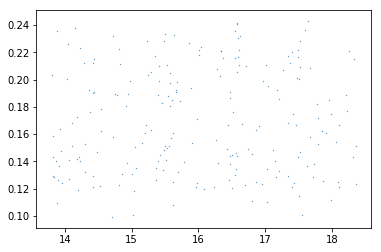

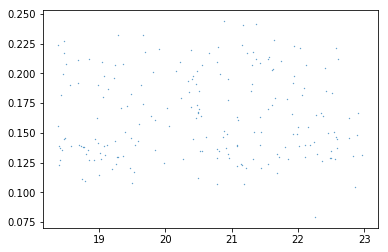

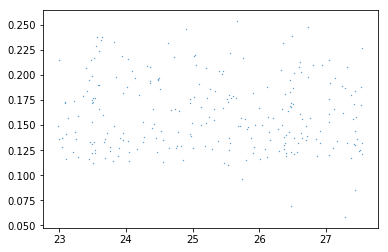

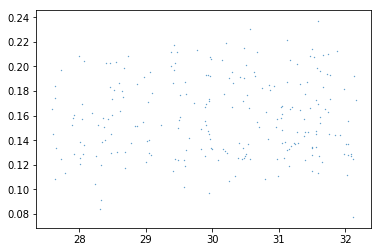

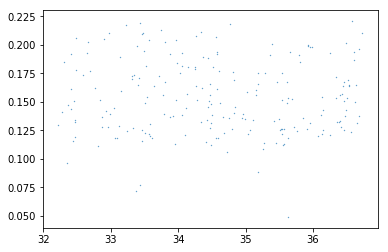

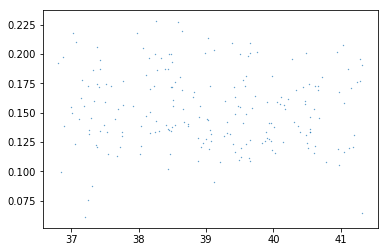

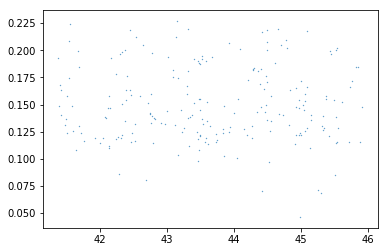

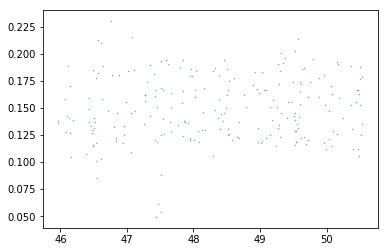

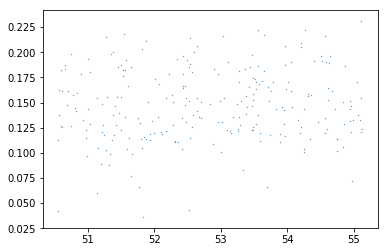

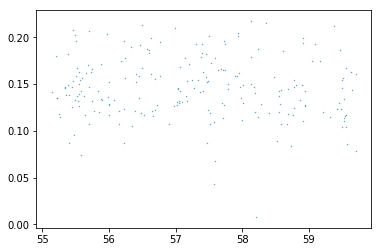

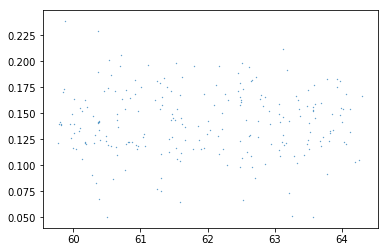

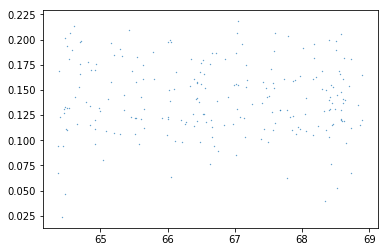

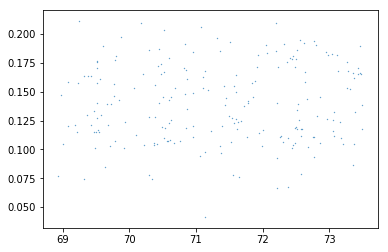

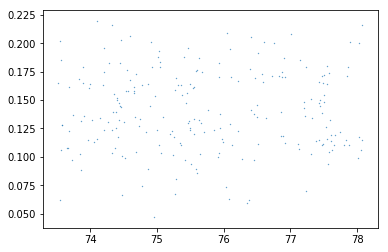

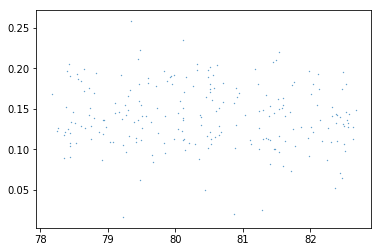

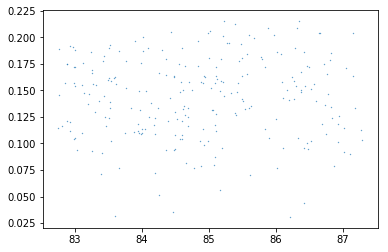

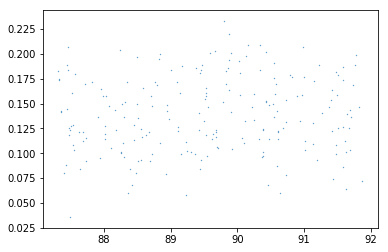

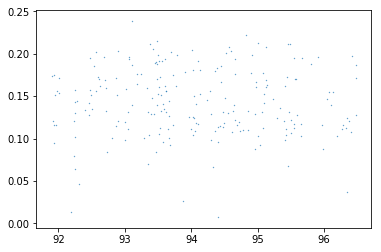

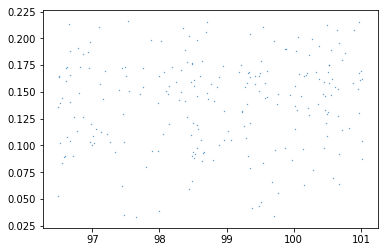

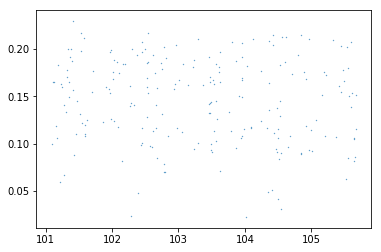

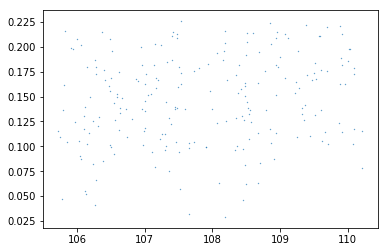

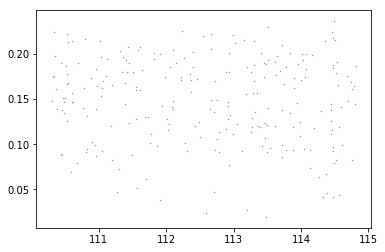

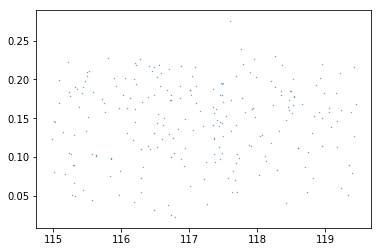

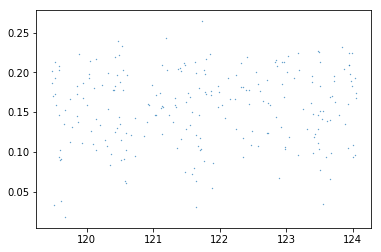

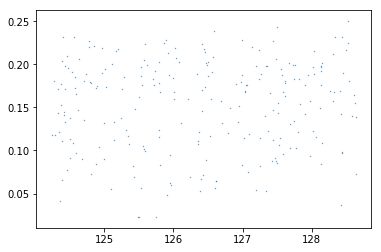

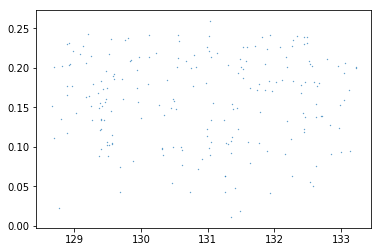

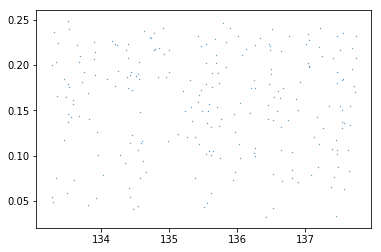

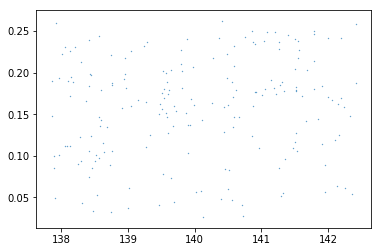

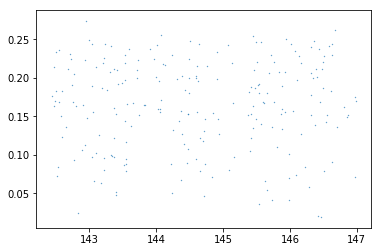

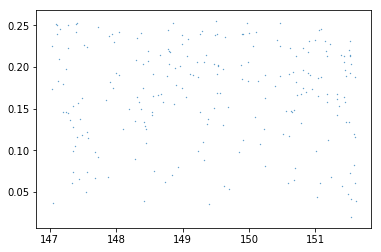

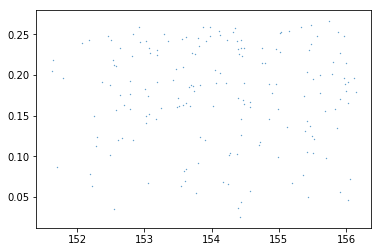

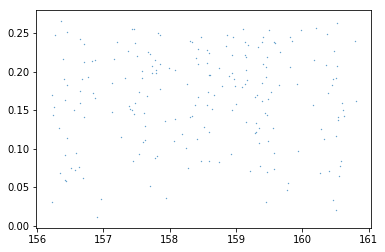

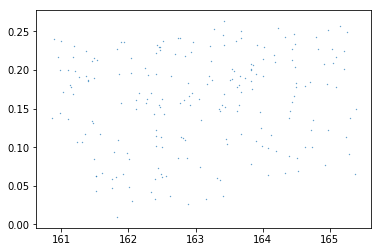

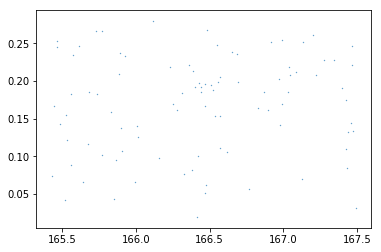

In [25]:
for i in range(nbatches):
    qs = [ np.linalg.norm(q) for q in q_batches[i] ]
    #preds = [ hkl[0]*bases[i]-ki_offsets[i] for hkl in hkl_batches[i] ]    
    #dq = [ np.linalg.norm(qs[j]-preds[j]) for j in range(len(q_batches[i]))]
    
    frames = frame_batches[i]
    
    preds = [q[0].dot(uc.basis()) for q in q_batches[i] ]    
    dhkl = [ np.linalg.norm(preds[j]-hkl_batches[i][j]) for j in range(len(q_batches[i]))]
       
    plt.scatter(frames, dhkl, s=0.1)
    plt.show()

In [26]:
for i in range(nbatches):
    duc = np.linalg.norm(bases[i]-uc.reciprocalBasis()) / np.linalg.norm(uc.reciprocalBasis())
    print(duc)

IndexError: list index out of range

In [27]:
predictor = nsx.PeakPredictor(data)

all_frames = []
all_deltas = []

for i in range(nbatches):
    deltas = []
    frames = []
    qs = []
    ds = []
    
    for j in range(len(q_batches[i])):
        hkls = nsx.vectorRowVector3d()
        hkls.push_back(hkl_batches[i][j])
        predicted_peak = predictor.predictPeaks(hkls, bases[i])
    
        for peak in predicted_peak:
           
            obs = center_batches[i][j]
            pred = peak.getShape().center()
            #print(obs-pred)
            
            delta = np.linalg.norm(obs-pred)
            
            
            # something clearly very wrong...
            if (delta > 10.0):
                peak_batches[i][j].setSelected(False)
                continue
                
            deltas.append(delta)
            
            frames.append(frame_batches[i][j])
            q = np.linalg.norm(peak.getQ().rowVector())
            qs.append(q)
            ds.append(1.0/q)
            
            all_frames.extend(frames)
            all_deltas.extend(deltas)
            
            
    #plt.scatter(frames, deltas, s=0.1)
    #plt.show()
            
plt.scatter(all_frames, all_deltas, s=0.1)
plt.show()

IndexError: list index out of range

In [28]:
source = data.getDiffractometer().source()
sample = data.getDiffractometer().sample()

source_gonio = source.getGonio()
sample_gonio = sample.getGonio()

def print_physical_axes(gonio):
    for i in range(gonio.getNAxes()):
        ax = gonio.getAxis(i)
    
        if not ax.isPhysical():
            continue
        
        print(i, ax.getLabel())
    
print_physical_axes(source_gonio)
print_physical_axes(sample_gonio)


0 om-mono
1 chi-mono
2 phi-mono
3 x-mono
4 y-mono
0 omega
1 chi
2 phi


In [54]:
peak_list = nsx.PeakList()

for peak in peaks:
    if not peak.isSelected():
        continue
        
    #q = peak.getQ()
    #hkl = uc.getIntegerMillerIndices(q)
    
    #error = np.linalg.norm(q.rowVector()-hkl.dot(uc.reciprocalBasis())) / np.linalg.norm(q.rowVector())
    
    #if error > 0.02:
    #    peak.setSelected(False)
     #   continue
        
    peak_list.push_back(peak)
    
print('refining for ', peak_list.size(), " peaks")

refiner = nsx.Refiner(uc, peak_list, nbatches)
refiner.refineB()

refiner.refineSamplePosition(data.getInstrumentStates())
#refiner.refineU()

#for i in range(6):
#    refiner.refineSampleState(data.getInstrumentStates(), i)

#refiner.refineSource()

    
result = refiner.refine(200)
print(result)

refining for  8367  peaks
True


In [ ]:
states = data.getInstrumentStates()

ax = 5

sample_states = [ state.sample._offsets[ax] for state in states ]
#source_states = [ state.source._offsets[ax] for state in states ]

plt.plot(sample_states)
plt.show()

#plt.plot(source_states)
#plt.show()

In [ ]:
ki = np.array([[0.,1.,0.]]).transpose()
dk = [ np.linalg.norm(source_gonio.transformInverse(ki, state.source) - ki) for state in states ]

plt.plot(dk)
plt.show()

In [ ]:
batches = refiner.batches()
peak_batches = [ [] for batch in batches ]

batch_id = 0

for batch in batches:
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        frame = peak.getShape().center()[2,0]
        
        if batch.contains(frame):
            peak_batches[batch_id].append(peak)
            
    batch_id += 1

for i in range(len(batches)):
    batch = batches[i]
    basis = batch.cell().reciprocalBasis()
    
    hkls = []
    frames = []
    qs = []
    ds = []
    pxs = []
    dqs = []
    
    for peak in peak_batches[i]:
        q = peak.getQ()
        hkl = batch.cell().getIntegerMillerIndices(q)
        center = peak.getShape().center()
        
        qs.append(np.linalg.norm(q.rowVector()))
        hkls.append(hkl)
        
        dq = q.rowVector() - hkl.dot(basis)
        dqs.append(np.linalg.norm(dq))
        
        frames.append(center[2,0])
        
        if np.linalg.norm(dq)/np.linalg.norm(q.rowVector()) > 0.02:
            peak.setSelected(False)
        
    plt.scatter(qs, np.array(dqs) / np.array(qs))
    plt.show()

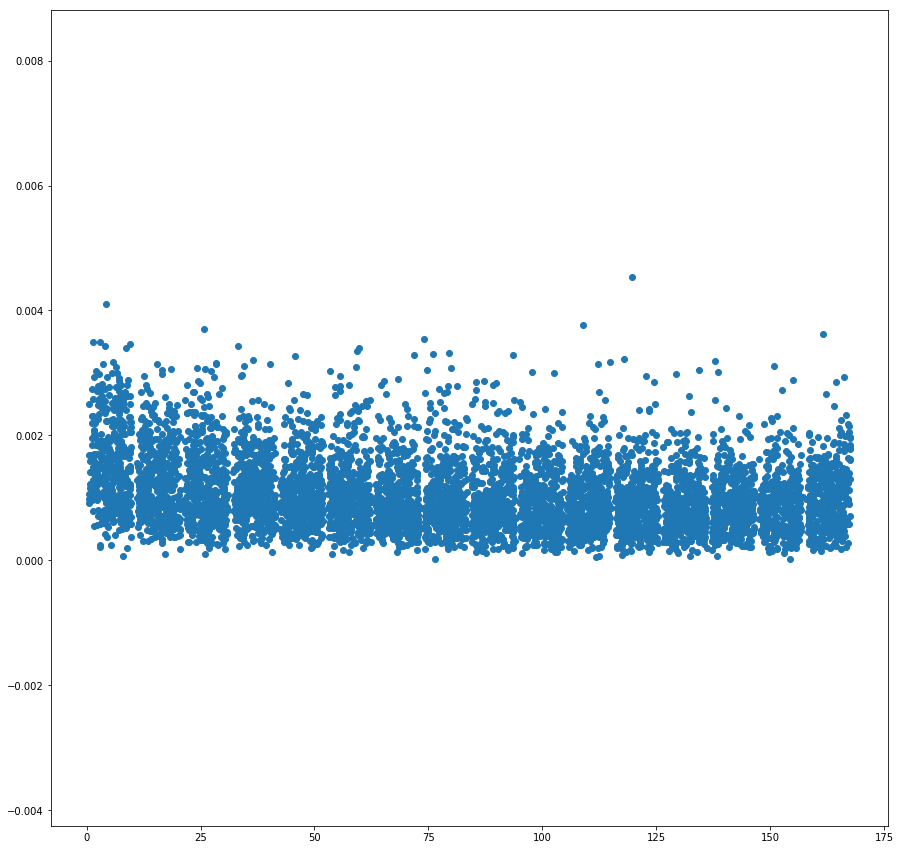

0.00104655438708


In [55]:
predictor = nsx.PeakPredictor(data)
batches = refiner.batches()

deltas = []
frames = []
qs = []
ds = []
dqs = []

for batch in batches:
    
    for peak in batch.peaks():
        hkls = nsx.vectorRowVector3d()
        hkls.push_back(np.array(batch.cell().getIntegerMillerIndices(peak.getQ()), dtype=float))
        predicted_peak = predictor.predictPeaks(hkls, batch.cell().reciprocalBasis())
    
        if (len(predicted_peak) == 0):
            peak.setSelected(False)
    
        for pred_peak in predicted_peak:
           
            obs = peak.getShape().center()
            pred = pred_peak.getShape().center()
            #print(obs-pred)
            
            delta = np.linalg.norm(obs-pred)
                        
            # something clearly very wrong...
            if (delta > 7.0):
                peak.setSelected(False)
                continue
                
            deltas.append(delta)
            
            frames.append(obs[2,0])
            q = np.linalg.norm(peak.getQ().rowVector())
            qs.append(q)
            ds.append(1.0/q)
            dqs.append(np.linalg.norm(pred_peak.getQ().rowVector()-peak.getQ().rowVector()))
            
fig = plt.figure(figsize=(15,15))    
plt.scatter(frames, dqs)
plt.show()
print(sum(dqs) / len(dqs))

blah blah lbah

## blah 
blah

### blah

* sdfg
* sdfg
* fghfgh

hello $\int_0^1 x dx$

In [46]:
help(open)

Help on built-in function open in module io:

open(file, mode='r', buffering=-1, encoding=None, errors=None, newline=None, closefd=True, opener=None)
    Open file and return a stream.  Raise IOError upon failure.
    
    file is either a text or byte string giving the name (and the path
    if the file isn't in the current working directory) of the file to
    be opened or an integer file descriptor of the file to be
    wrapped. (If a file descriptor is given, it is closed when the
    returned I/O object is closed, unless closefd is set to False.)
    
    mode is an optional string that specifies the mode in which the file
    is opened. It defaults to 'r' which means open for reading in text
    mode.  Other common values are 'w' for writing (truncating the file if
    it already exists), 'x' for creating and writing to a new file, and
    'a' for appending (which on some Unix systems, means that all writes
    append to the end of the file regardless of the current seek position

In [56]:
help(nsx.ResolutionShell)

Help on class ResolutionShell in module pynsx:

class ResolutionShell(builtins.object)
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, dmin, dmax, num_shells)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_ResolutionShell(...)
 |  
 |  addPeak(self, peak)
 |  
 |  getD(self)
 |  
 |  getShells(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __swig_getmethods__ = {}
 |  
 |  __swig_setmethods__ = {}

